## Backgroud:
 Kinases play a crucial role in cellular signalling, making them important targets for drug development. Dysregulation of kinases is frequently implicated in diseases like cancer, inflammation, and neurodegenerative disorders. Therefore, targeting kinases with specific drugs has emerged as a crucial strategy in modern drug discovery. Kinase-related task includes inhibition prediction, selectivity prediction, or kinase-ligand binding affinity prediction. In the early release version of Polaris, benchmarks were established for kinases such as EGFR, KIT, and RET, along with their respective mutations, as well as for LOK and SLK.


## Description of readout 
- **Readouts**: `EGFR`, `KIT`, `RET`, `LOK`, `SLK`
- **Bioassay readout**: Percentage of inhibition (%).
- **Optimization objective**: Higher potency (higher %inhibition).


## Data resource:
PKIS2: A second chemogenomics set of kinase inhibitors from GSK, Takeda, and Pfizer was assembled as PKIS2. This set contained 645 inhibitors and included many additional chemotypes that were not represented in the original set.

**Reference**: https://www.ncbi.nlm.nih.gov/pubmed/28767711

<!-- ## Related benchmarks -->
<!-- TODO: to be added -->

In [1]:
%load_ext autoreload
%autoreload 2
import datamol as dm
import pandas as pd
from polaris import curation
import datetime
import re
from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID

import os
import pathlib
os.chdir(pathlib.Path("__file__").absolute().parents[2])
import warnings
warnings.filterwarnings("ignore")

In [2]:
INDIR = "gs://polaris-public/data/raw"
OUTDIR = "gs://polaris-public/data/Kinases"

## Load the raw data
The dataset is published in https://pubmed.ncbi.nlm.nih.gov/26501955

In [3]:
data = pd.read_parquet(f"{INDIR}/pkis_matrix_1uM.parquet")
data.head(5)

Assay Description,Smiles,ABL1 (E255K mutant),ABL1 (H396P mutant),ABL1 (M351T mutant),ABL1 (Q252H mutant),ABL1 (T315I mutant),ABL1 (Y253F mutant),ABL1,AKT1,AKT2,...,TRKC,TSSK1,TSSK2,TTK,TXK,TYK2,TYRO3,YES,ZAP70,p70s6K1
0,C#Cc1cccc(Nc2ncnc3ccc(OCCCCNCCS(C)(=O)=O)cc23)c1,19.66,22.98,19.21,22.70,19.38,24.85,26.77,-3.06,-2.09,...,4.94,6.34,2.71,9.83,7.94,-1.47,8.46,12.33,-2.29,3.29
1,C/C(Nc1ccc(S(N)(=O)=O)cc1)=C1/C(=O)Nc2ccccc21,3.45,7.24,14.69,13.58,12.24,12.78,11.68,-1.45,-0.17,...,87.09,5.46,1.13,35.67,-0.74,6.88,16.80,14.10,0.18,2.17
2,CC(=O)NCc1cccc(C#Cc2cncnc2Nc2ccc(OCc3cccc(F)c3...,1.65,-0.68,-0.38,-0.70,1.56,2.58,2.82,-1.16,0.71,...,4.11,2.15,1.59,-8.10,-2.24,2.95,0.40,6.04,2.22,0.74
3,CC(=O)Nc1cccc(C#Cc2cncnc2Nc2ccc(OCc3cccc(F)c3)...,1.79,1.25,2.92,2.16,1.79,3.28,8.55,2.86,1.24,...,1.69,0.24,-1.88,7.90,8.59,0.26,0.81,1.70,6.95,2.07
4,CC(=O)Nc1cccc(C#Cc2cncnc2Nc2ccc(OCc3cccc(F)c3)...,-0.48,1.60,3.88,3.02,2.23,1.84,4.88,0.42,-0.21,...,4.04,4.75,5.54,10.84,0.46,2.39,1.63,10.68,-0.49,0.93


In [4]:
path = "gs://polaris-public/data/raw/drewry_pone_2017_SI_S4_Table.xlsx"
data = pd.read_excel(path)[:-1]

In [5]:
data.shape

(645, 413)

### Define data columns and structure column. Remove empty rows.

In [6]:
data.rename(columns={col: col.replace(" ", "_") for col in data.columns}, inplace=True)
mol_col = "Smiles"
data_cols = ['EGFR', 'KIT', 'LOK', 'RET', 'SLK' ]
data = data[[mol_col] + data_cols]
data = data.dropna(subset=data_cols, how="all", axis=0)

In [7]:
data.shape

(645, 6)

### Define threshold for classification conversion
> The authors in the reference paper used a stringent threshold `%inhibition > 90` to identify the hit. Here, we loss the thresholds according to the distributions. 

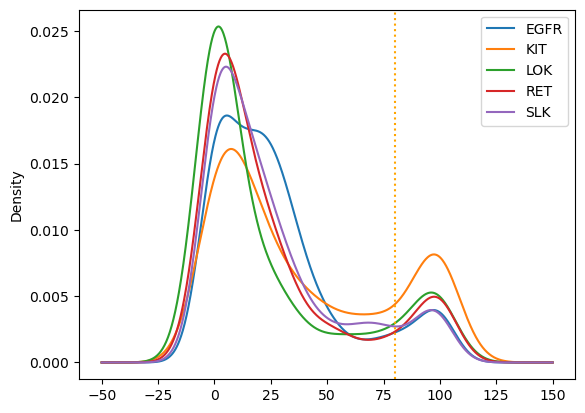

In [8]:
from matplotlib import pyplot as plt
data[data_cols].plot.kde()
plt.axvline(x=80, linestyle="dotted", color="orange")

In [9]:
th = 80   
class_thresholds = {col: {"thresholds": [th]} for col in data_cols}

### Run preliminary curation for data inspection
> See detailed documention of the data curation in [Polaris library](https://github.com/polaris-hub/polaris/blob/92888919194db9ad70b77fa55e10a7954c372eb9/polaris/curation/_curator.py#L13C13-L13C13)

In [10]:
# curate
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    class_thresholds=class_thresholds,
    keep_all_rows=True,
)
df_full = curator_with_stereo()

[<Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>]

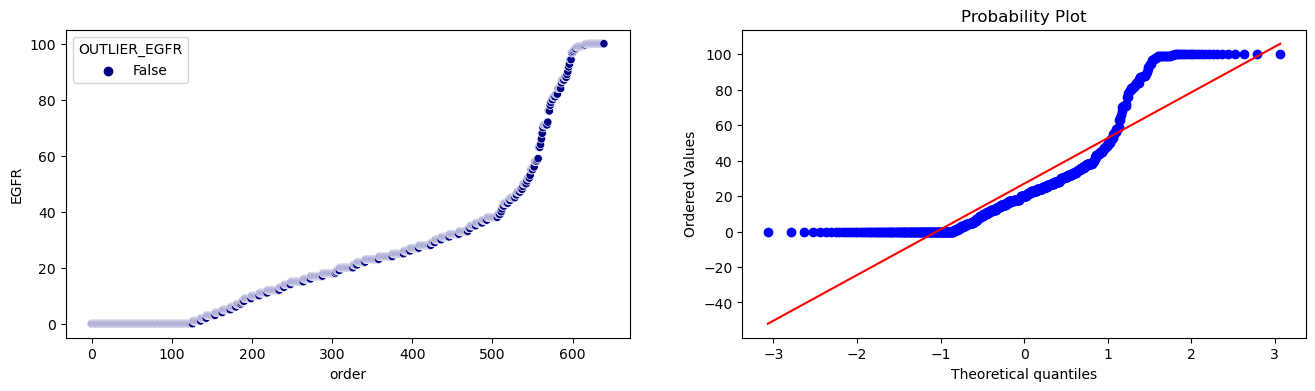

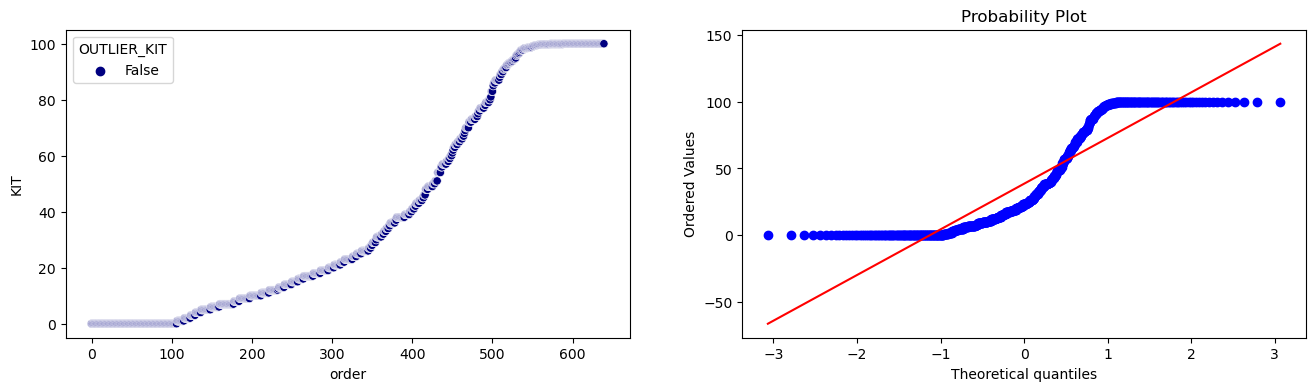

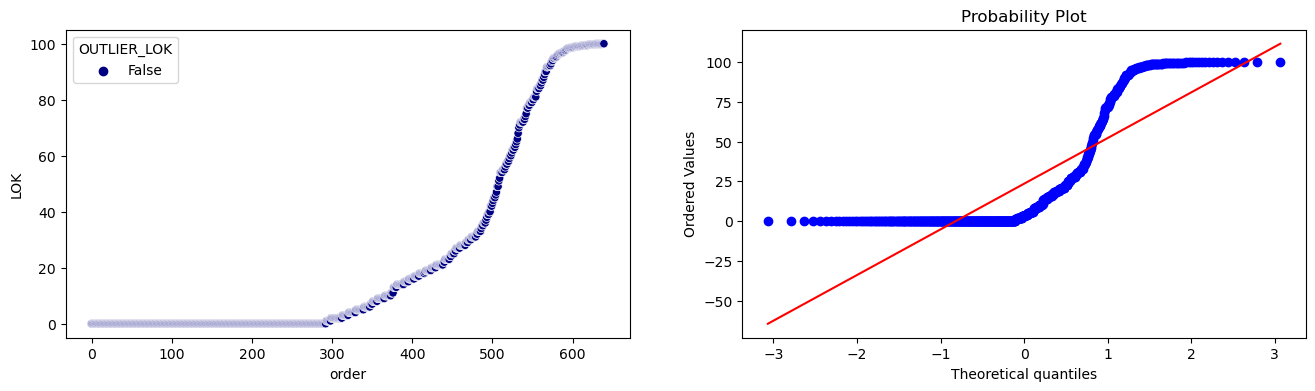

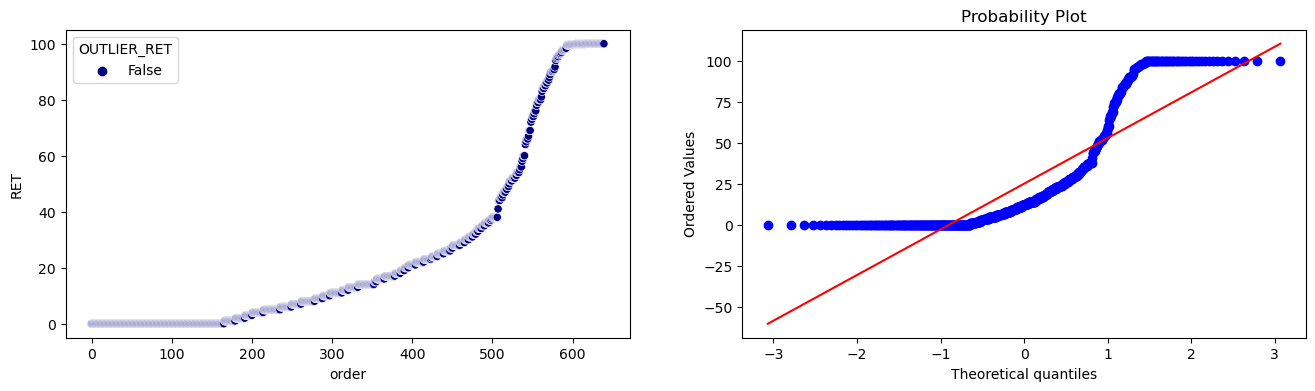

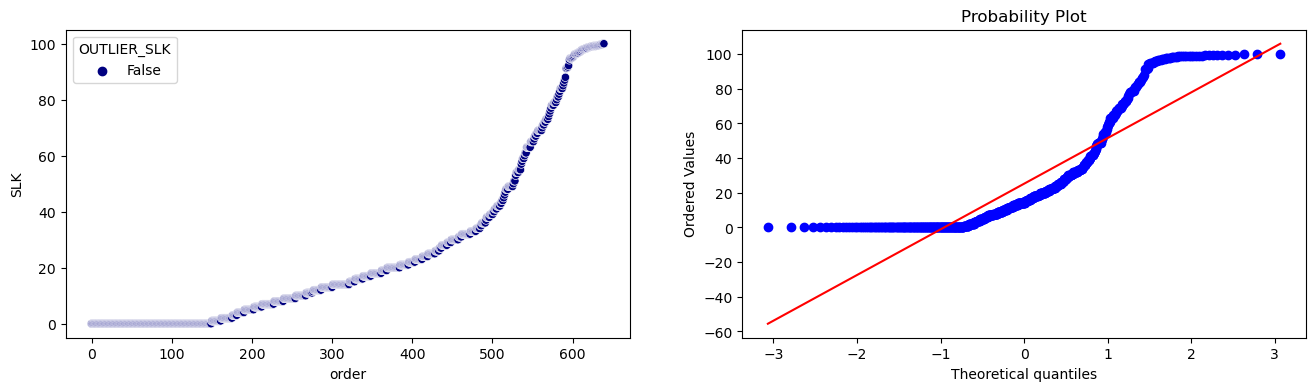

In [11]:
from polaris.curation.viz_utils import visulize_distribution
visulize_distribution(dataset=df_full, data_cols=data_cols)

### Check the activity shift between the stereo isomers

In [12]:
df_full[[col for col in df_full.columns if 'stereo_cliff' in col]].sum()

CLASS_EGFR_stereo_cliff    0
CLASS_KIT_stereo_cliff     0
CLASS_LOK_stereo_cliff     0
CLASS_RET_stereo_cliff     0
CLASS_SLK_stereo_cliff     0
dtype: object

No activity shifts have been detected in the dataset.

### Check the molecules with undefined stereocenters

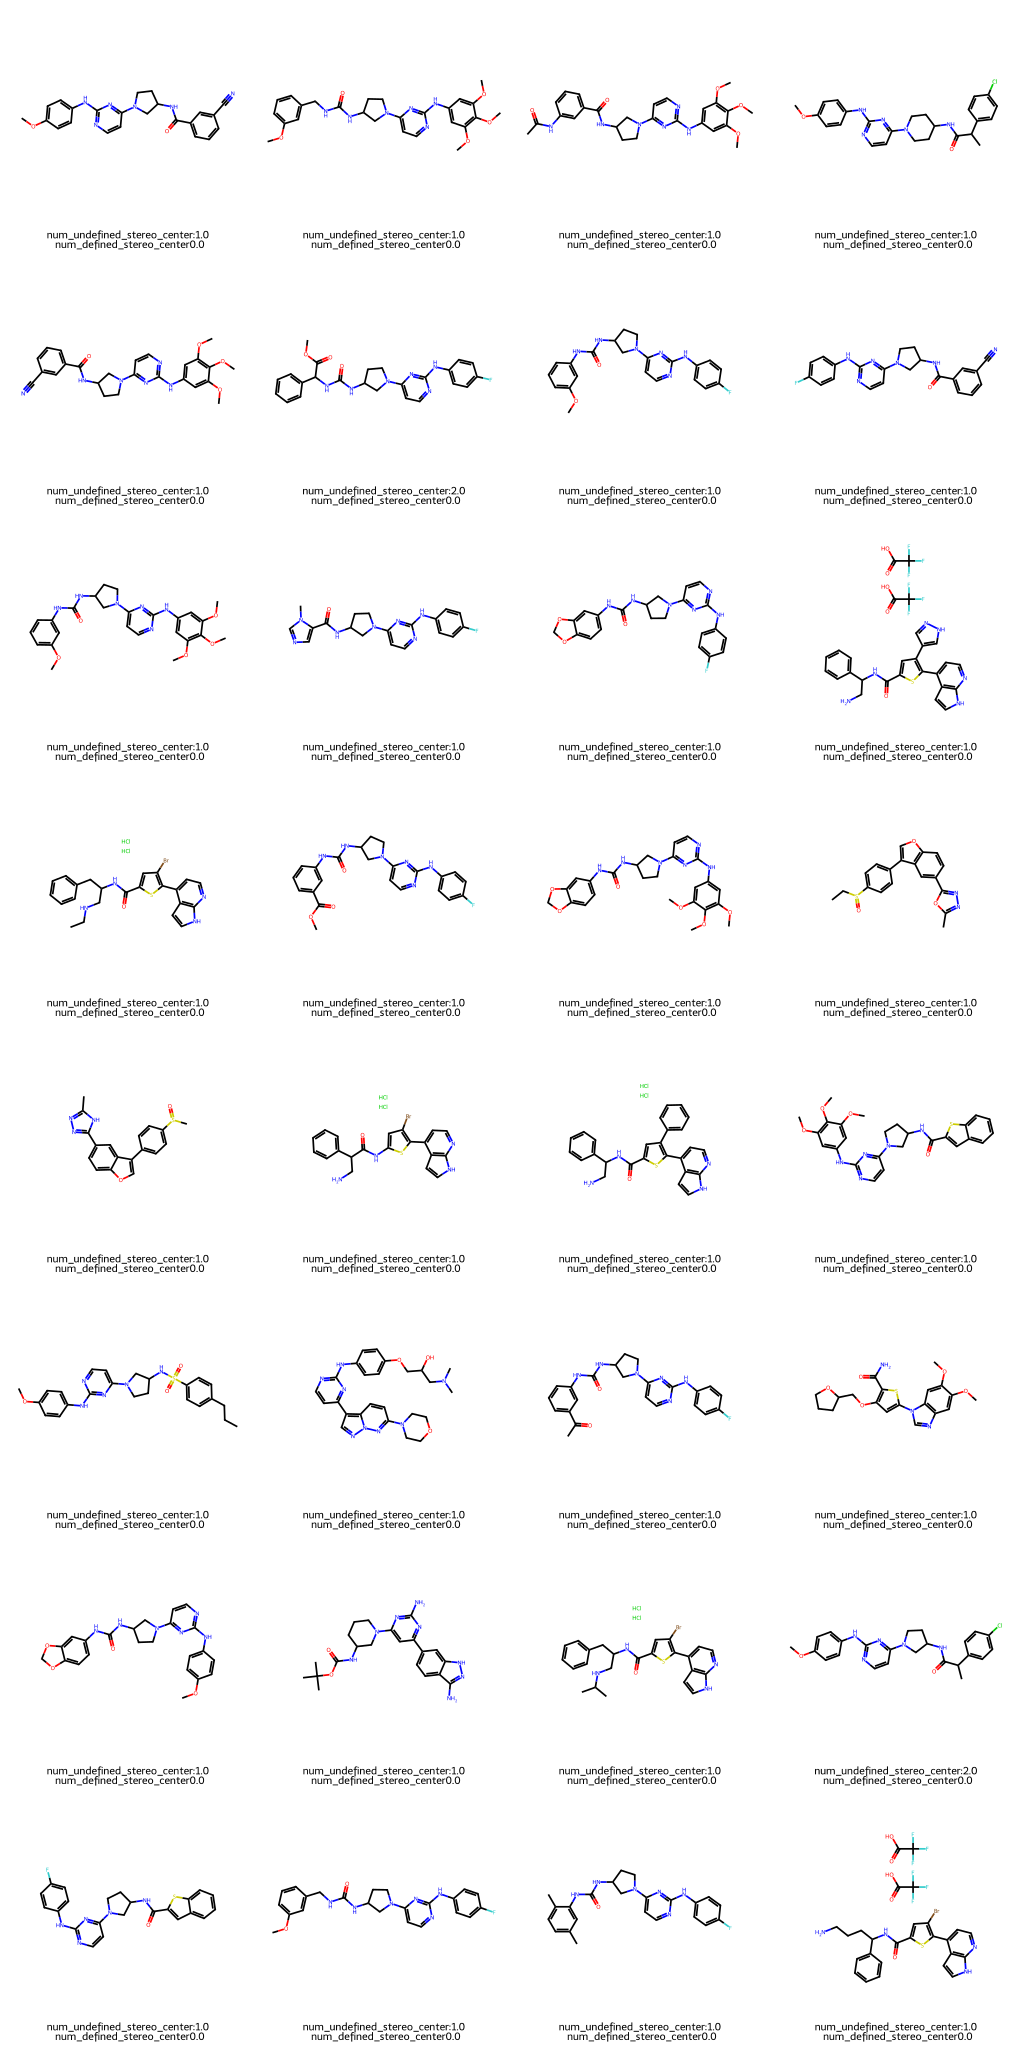

In [13]:
from polaris.curation.viz_utils import check_undefined_stereocenters
df_full['mol'] = df_full[mol_col].apply(dm.to_mol)
fig, unspecified_df = check_undefined_stereocenters(dataset=df_full)
fig

<Axes: >

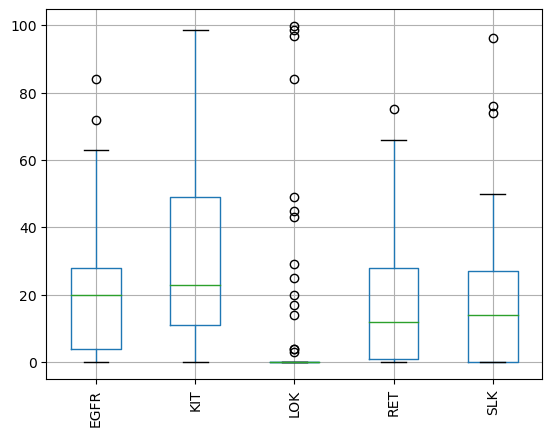

In [14]:
unspecified_df[data_cols].boxplot(rot=90)

The stereo center of the above molecules are unspecified. Several data compounds show higher inhibition, although the overall % inhibition is in the low to medium range. kinase LOK and two EGFR mutants. However, there are no activity shifts between the stereo isomers have been detected in this dataset. Therefore, we keep the above molecules in the dataset.

### Rerun the curation steps

In [15]:
# curate
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    # remove molecules which has undefined stereocenter and also show activity shift to the sterepisomers
    mask_stereo_undefined_mols=True, 
    class_thresholds=class_thresholds,
    # remove all the molecules rows including the duplicates
    keep_all_rows=False,
)
df_full = curator_with_stereo()

In [16]:
df_full

,Smiles,EGFR,KIT,LOK,RET,SLK,ORIGINAL_EGFR,ORIGINAL_KIT,ORIGINAL_LOK,ORIGINAL_RET,...,CLASS_EGFR,CLASS_KIT,CLASS_LOK,CLASS_RET,CLASS_SLK,CLASS_EGFR_stereo_cliff,CLASS_KIT_stereo_cliff,CLASS_LOK_stereo_cliff,CLASS_RET_stereo_cliff,CLASS_SLK_stereo_cliff
0,FC(F)(F)c1ccc(cc1)-c1ncn(CCCN2CCOCC2)c1-c1ccncc1,19.0,20.0,10.0,20.0,0.0,19.0,20.0,10.0,20.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,CSc1ccc(NC2=C(C(=O)NC2=O)c2ccccc2Cl)cc1,18.0,25.0,2.0,14.0,98.7,18.0,25.0,2.0,14.0,...,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
2,COc1ccccc1C1=C(Nc2cccc(O)c2)C(=O)NC1=O,0.0,11.0,28.0,4.0,98.8,0.0,11.0,28.0,4.0,...,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
3,COc1ccc(CNC(=O)NC2CCN(CC2)c2ccnc(Nc3ccc(F)cc3)...,13.0,19.0,0.0,0.0,7.0,13.0,19.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,CCC1=CC=C(C=C1)C1=CC=C2N(C)S(=O)(=O)C3=CN(C)N=...,0.0,0.0,2.0,16.0,12.0,0.0,0.0,2.0,16.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,NC(=O)c1nnc2ccccc2c1N,0.0,10.0,10.0,8.0,0.0,0.0,10.0,10.0,8.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
636,O=C1NN=CC2=C(C3=CN(C)N=C3)NC4=CC(NC([C@@H](C5C...,81.0,99.9,17.0,100.0,14.0,81.0,99.9,17.0,100.0,...,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
637,O=C(N1CCOCC1)c1ccc(cc1)-c1cc(ccn1)-c1c[nH]nc1-...,4.0,0.0,28.0,0.0,0.0,4.0,0.0,28.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
638,CSc1ccc(NC2=C(C(=O)NC2=O)c2cccc(Cl)c2)cc1,2.0,0.0,0.0,0.0,31.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [17]:
fout = f"{OUTDIR}/pkis2_subset_curated_v1.parquet"
df_full.to_parquet(fout, index=False)

In [18]:
df_full.dropna(subset=data_cols, axis=0, how="all")

,Smiles,EGFR,KIT,LOK,RET,SLK,ORIGINAL_EGFR,ORIGINAL_KIT,ORIGINAL_LOK,ORIGINAL_RET,...,CLASS_EGFR,CLASS_KIT,CLASS_LOK,CLASS_RET,CLASS_SLK,CLASS_EGFR_stereo_cliff,CLASS_KIT_stereo_cliff,CLASS_LOK_stereo_cliff,CLASS_RET_stereo_cliff,CLASS_SLK_stereo_cliff
0,FC(F)(F)c1ccc(cc1)-c1ncn(CCCN2CCOCC2)c1-c1ccncc1,19.0,20.0,10.0,20.0,0.0,19.0,20.0,10.0,20.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,CSc1ccc(NC2=C(C(=O)NC2=O)c2ccccc2Cl)cc1,18.0,25.0,2.0,14.0,98.7,18.0,25.0,2.0,14.0,...,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
2,COc1ccccc1C1=C(Nc2cccc(O)c2)C(=O)NC1=O,0.0,11.0,28.0,4.0,98.8,0.0,11.0,28.0,4.0,...,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
3,COc1ccc(CNC(=O)NC2CCN(CC2)c2ccnc(Nc3ccc(F)cc3)...,13.0,19.0,0.0,0.0,7.0,13.0,19.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,CCC1=CC=C(C=C1)C1=CC=C2N(C)S(=O)(=O)C3=CN(C)N=...,0.0,0.0,2.0,16.0,12.0,0.0,0.0,2.0,16.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,NC(=O)c1nnc2ccccc2c1N,0.0,10.0,10.0,8.0,0.0,0.0,10.0,10.0,8.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
636,O=C1NN=CC2=C(C3=CN(C)N=C3)NC4=CC(NC([C@@H](C5C...,81.0,99.9,17.0,100.0,14.0,81.0,99.9,17.0,100.0,...,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
637,O=C(N1CCOCC1)c1ccc(cc1)-c1cc(ccn1)-c1c[nH]nc1-...,4.0,0.0,28.0,0.0,0.0,4.0,0.0,28.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
638,CSc1ccc(NC2=C(C(=O)NC2=O)c2cccc(Cl)c2)cc1,2.0,0.0,0.0,0.0,31.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [19]:
fout

'gs://polaris-public/data/Kinases/pkis2_subset_curated_v1.parquet'